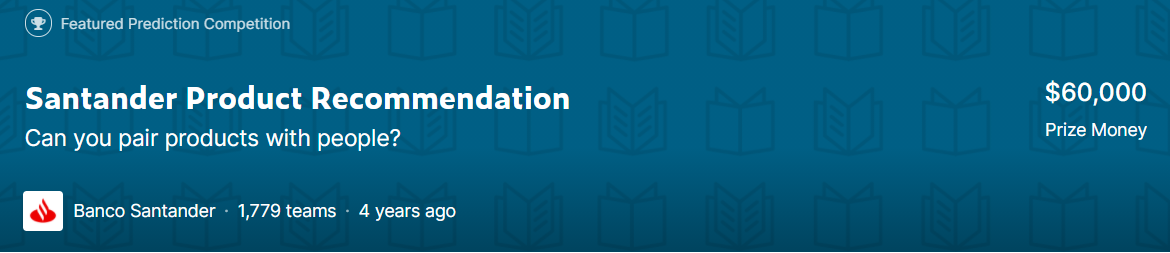

### Preview
Ready to make a downpayment on your first house? Or looking to leverage the equity in the home you have? To support needs for a range of financial decisions, Santander Bank offers a lending hand to their customers through personalized product recommendations.



Under their current system, a small number of Santander’s customers receive many recommendations while many others rarely see any resulting in an uneven customer experience. In their second competition, Santander is challenging Kagglers to predict which products their existing customers will use in the next month based on their past behavior and that of similar customers.

With a more effective recommendation system in place, Santander can better meet the individual needs of all customers and ensure their satisfaction no matter where they are in life.

Disclaimer: This data set does not include any real Santander Spain's customer, and thus it is not representative of Spain's customer base. 

### Data Description
- In this competition, you are provided with 1.5 years of customers behavior data from Santander bank to predict what new products customers will purchase. - The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit card", "savings account", etc. You will predict what additional products a customer will get in the last month, 2016-06-28, in addition to what they already have at 2016-05-28. 
- These products are the columns named: ind_(xyz)_ult1, which are the columns #25 - #48 in the training data. 
- You will predict what a customer will buy in addition to what they already had at 2016-05-28. 

- The test and train sets are split by time, and public and private leaderboard sets are split randomly.

- Please note: This sample does not include any real Santander Spain customers, and thus it is not representative of Spain's customer base. 

### File descriptions
1. train.csv 
  - the training set
2. test.csv 
  - the test set
3. sample_submission.csv 
  - a sample submission file in the correct format





In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beasterea1109","key":"279cae26f5489744999fb4892f9b1c35"}'}

In [ ]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c santander-product-recommendation

 40% 5.00M/12.4M [00:00<00:00, 21.8MB/s]
100% 12.4M/12.4M [00:00<00:00, 41.3MB/s]
  0% 0.00/2.28M [00:00<?, ?B/s]
100% 2.28M/2.28M [00:00<00:00, 75.0MB/s]
 98% 210M/214M [00:04<00:00, 47.6MB/s]
100% 214M/214M [00:04<00:00, 46.3MB/s]


In [ ]:
# 다운로드 된 것들 다 보기 
!ls
# 필요하면 압축 풀기 
!unzip sample_submission.csv.zip
!unzip test_ver2.csv.zip
!unzip train_ver2.csv.zip

kaggle.json  sample_submission.csv.zip	train_ver2.csv.zip
sample_data  test_ver2.csv.zip
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test_ver2.csv.zip
  inflating: test_ver2.csv           
Archive:  train_ver2.csv.zip
  inflating: train_ver2.csv          


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Testdf = pd.read_csv('/content/drive/MyDrive/BOAZ_MINI_PROJECT_KAGGLE/test_ver2.csv/test_ver2.csv', low_memory = False)
Traindf = pd.read_csv('/content/drive/MyDrive/BOAZ_MINI_PROJECT_KAGGLE/train_ver2.csv/train_ver2.csv', low_memory = False)

In [ ]:
Testdf.head(3)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,NaN,1.0,A,S,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,NaN,1.0,I,S,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES
2,2016-06-28,1170545,N,ES,V,22,2013-08-28,0,34,1,NaN,1.0,A,S,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,NA,03 - UNIVERSITARIO


In [ ]:
Traindf.head(3)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35.0,0.0,6,1.0,1.0,A,S,N,NaN,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23.0,0.0,35,1.0,1,I,S,S,NaN,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23.0,0.0,35,1.0,1,I,S,N,NaN,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
# age데이터가 수치형이지만 문자열의 형태이기 떄문에 pd.to_numeric()함수를 이용해서 바꾸어 준다.
Traindf['age'] = pd.to_numeric(Traindf['age'], errors = "coerce")

### DATA EDA + PREPROCESSING
1. 학습을 용이하게 하기 위해서 입력하기 좋은 시계열 데이터로 바꾸어주자.
2. 그 전에 먼저 고객 id에 따라서 sorting을 진행해 보는 것도 좋을 것 같다.
3. idnull()을 이용해서 비어있는 데이터를 확인해 본다.

In [ ]:
# 결측치가 있는 데이터가 있을 수 있으니 이를 확인해 보자
Traindf.isnull().any()

-> 속성 관련 데이터의 경우에 거의 모든 데이터에 대해서 결측치가 있음이 확인 가능했다.

In [ ]:
Traindf.drop(columns = ['fecha_alta','canal_entrada','ult_fec_cli_1t'], axis=1, inplace=True)

In [ ]:
df = pd.DataFrame(Traindf.ncodpers)
df.head(3)

,ncodpers
0,1375586
1,1050611
2,1050612


In [ ]:
# 데이터의 개수가 17개인 사람에 대해서만 저장
# 시계열 데이터의 길이를 padding을 통해 맞춰주려고 하려면 NLP처럼 vocab dictionary등의 정보가 있는 것이 좋은데, 그렇지 않은 경우에는 그냥 데이터의 길이를 처음부터 맞추어 주는것이 낫다.
IDlist = []
for ID, value in dict(df['ncodpers'].value_counts()).items():
  if value == 17:
    IDlist.append(ID)
# Dict_17에서 key : value가 dictionary의 형태임을 고려할 때에 key값이 위의 dataframe에서의 index이고 value는 해당 멤버의 데이터의 개수가 저장이 되어 있을 것이다.
# 따라서 아래 코드를 이용해서 17보다 적은 개수의 데이터에 대해 drop을 한다.

- IDlist는 17개의 데이터를 모두 지니고 있는 멤버의 id가 저장이 되어있다.
- 우리는 Traindf['ncodpers']의 값이 IDlist에 있는 index만을 저장해서 데이터로 사용하고자 한다.  
#### 이를 위해서 어떻게 해야 할까????

In [ ]:
# 문자열 형태의 날짜 -> datetime 형태
Traindf['fecha_dato'] = pd.to_datetime(Traindf['fecha_dato'],format='%Y%m%d', errors='ignore')
Traindf = Traindf.sort_values(by = ['ncodpers', 'fecha_dato'])

In [ ]:
# 섞여버린 index에 대해서 모든 index를 0부터 오름차순으로 정수의 형태로 바꾸어 준다.
Traindf = Traindf.reset_index(drop = False, inplace = False)

In [ ]:
Traindf.tail(3)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
13296125,2016-05-28,1553687,N,ES,V,21.0,1.0,0,1.0,NaN,NaN,S,N,NaN,N,1.0,28.0,MADRID,0.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13296126,2016-05-28,1553688,N,ES,H,43.0,1.0,0,1.0,NaN,NaN,S,N,NaN,N,1.0,39.0,CANTABRIA,0.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13296127,2016-05-28,1553689,N,ES,V,40.0,1.0,0,1.0,NaN,NaN,S,N,NaN,N,1.0,21.0,HUELVA,0.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
13296128 / 17

782125.1764705882

- 이렇게 위와 같은 방법으로 우선 데이터를 고객에 따라서 정렬을 해 준 뒤에 문자열의 형태에서 timestep의 형태로 바꾸어준 'fecha_dato'를 이용한다.
- ```pd.sort_by()```를 이용하여서 먼저 id별로 모아준 뒤에 시계열 순서로 정렬을 한다.


```python
def lower_than(group,num):
    if len(group['fecha_dato']) < num:
        return None
    else :
        return group
```
- 원래는 위와 같은 lower_than함수를 적용해서 17개 이하의 데이터를 가진 사람을 drop해 주려 했으나 아무래도 그 많은 데이터에 apply를 적용하려니 + 일일히 개수를 비교하려니 시간이 GPU를 사용하고 있음에도 부족할 수 밖에 없는 듯 보인다.
- 그래서 그냥 value_counts()의 값이 17이 아닌 경우 해당 row에 대해 drop을 해서 적용을 했다.
- 따라서 Traindf를 Feature_df와 Target_df로 나눠놓고 미리 csv파일로 저장해 놓고자 한다.

In [ ]:
# Column에 대해서 Target과 Feature으로 나누어서 리스트로 저장하도록 한다.
TargetCol = Traindf.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
FeatureCol = [_ for _ in Traindf.iloc[:1,].columns.values if _ not in set(TargetCol)]
Feature_df = Traindf.loc[:,FeatureCol]
Target_df = Traindf.loc[:,TargetCol]

In [ ]:
Feature_df.head(3)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2015-01-28,15889,F,ES,V,56.0,0.0,245,1.0,1,A,S,N,N,N,1.0,28.0,MADRID,1.0,326124.9,01 - TOP
1,2015-02-28,15889,F,ES,V,56.0,0.0,245,1.0,1,A,S,N,N,N,1.0,28.0,MADRID,1.0,326124.9,01 - TOP
2,2015-03-28,15889,F,ES,V,56.0,0.0,245,1.0,1,A,S,N,N,N,1.0,28.0,MADRID,1.0,326124.9,01 - TOP


In [ ]:
Target_df.head(3)

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0
2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0


데이터에 지금까지 진행한 전처리 과정은
1. age데이터 수치화
2. isnull() == True가 나온 column중에 3개(  
  ['fecha_alta','canal_entrada','ult_fec_cli_1t']  
) 제거
3. 데이터가 17개의 모든 날짜에 대해 존재하는 인물들만 남기고 모두 제거 (시퀀스 데이터 분석을 위해서)
4. fecha_dato의 column에 대해서 datetime의 형태로 바꾸어 준다.
5. 각 사람의 속성인 Feature_df와 해당 사람의 구매 내역인 Target_df로 나누어 주었다.

In [ ]:
# 수치형 데이터가 아닌 Object 형태의 데이터에 대해서 Column명을 리스트로 저장한 이후에 OneHotEncoding을 진행해 준다.
ObjectCol = Traindf.select_dtypes(include = 'object').columns



```python
Feature_df = pd.get_dummies(Feature_df, prefix = ObjectCol, drop_first = True) # pd.DataFrame의 형태로 반환을 해 준다.
```


- pandas dataframe에 대해서 숫자가 아닌 그냥 문자가 들어간 문자열에는 as_numeric() 함수를 적용하면 value error이 뜨기 때문에 적용이 불가능하다.  

**원래는 데이터 중에서 문자가 열에 들어간 경우에는 get_dummmies를 사용해서 위의 코드와 같은 방법으로 데이터에 대해 one-hot을 진행하려 했으나 one-hot을 적용하게 되면 데이터의 크기가 너무 커진다.**  

- 그렇기 때문에 모든 문자형 데이터에 대해서는 각각의 column에 따라서 다르게 값의 변환을 적용시켜 주는 것이 맞다.

In [ ]:
# Min-Max Scaler을 이용해서 속성 train 데이터만을 0에서 1사이의 수치형 데이터로 바꾸어줌
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
Scaled_df = Scaler.fit_transform(Feature_df) # Fit to data, then transform it.

# 나중에 target과 합쳐서 사용해야 하기 때문에 pd.DataFrame의 형태로 바꾸어 준다.
Feature_df =pd.DataFrame(Scaled_df, columns = Feature_df.columns)

print(Feature_df.shape, Target_df.shape)


In [ ]:
# 만들어 놓은 Feature_df, Target_df를 저장한다.
Feature_df.to_csv('Train_Feature_df1.csv')
Target_df.to_csv('Train_Target_df1.csv')

### ANALYSIS
- 데이터를 x, y(target)으로 나누어 보자 
- 우선 우리가 예측해야 하는 데이터는 24번째 column의 데이터부터 끝까지 모두인데, 따라서 이를 담은 target_df와 앞부분을 담을 input_df로 나누고자 한다.
- 그 이후에는 불필요한 입력 데이터를 상관계수 및 차원 축소 clustering, 그리고 svd를 이용하는 등의 객관적인 지표를 이용해 입력 데이터를 예측에 용이하도록 EDA를 진행해 줄 것이다.
- 이후에 sklearn의 train_test_split으로 데이터를 나누어준 다음에 학습을 위한 모델을 설계해야 한다.
- 학습에 사용하게 될 target data의 경우에는 one-hot encoding을 통해서 수치형으로 labeling을 진행해 준 다음에 각각의 customer마다 크기가 1인 데이터로 바꾸어 준다. = 하나의 값으로 분류(예측)을 하는 문제로 바뀌는 것이다.
  1. 시계열 데이터로 본다(?) -> 이렇게 바라볼 수 있는 방법이 있을까???
  2. 1D의 CNN모델 (Convolution Layer + Max Pool Layer)을 이용해서 특징 추출을 해준 이후에 encoder-decoder을 적용하여서 마지막에 출력 unit이 1인 Dense Layer을 이용해서 예측을 진행한다.
  -> CNN모델의 경우 전이학습을 통해서 마지막 layer제외 나머지 layer은 모두 ```layer.trainable = False```로 지정해서 특징 추출을 할 수도 있다.
    - 이때 마지막 Dense Layer의 activation function으로 지정을 따로 해 줄 필요가 없고, 나머지 Dense Layer들은 **relu**를 사용할 것이다.
    - loss function으로는 **MSE**를 사용한다. 
    - optimizer으로는 **RMSProp**을 사용한다. (optimizer은 gradient descent를 계산해주는 역할을 함)
    - 과적합을 막기 위해서 사용할 방법으로 가능한 것은 
      1. Regularization(L1 norm, L2 norm, Xavier norm)
      2. EarlyStopping  
#### FINAL MODEL
 **CNN + RNN 그리고 최종 출력은 Fully Connected Dense Layer**
  1. 우선 CNN 모델을 이용해서 해당 속성에 대해서는 이러한 물건을 샀음을 학습시킨다. 
    - 이 CNN모델로부터 이용할 것은 속성 입력시에 예측하는 구매 물건이다.(output)
  2. 그리고 RNN 모델을 이용해서 시계열 데이터를 학습시킨다. 데이터중에서 17개의 시계열 데이터를 보유하고 있는 사람만 남겨 놓았으므로 이를 이용해서 1달 단위로 어떻게 구매 내역이 바뀌는지에 대한 길이가 17일 시계열 데이터를 만들어 입력한 후에 하나하나 예측하도록 한다. (window method를 적용)
    - 이렇게 학습 시키면 이 RNN 모델은 입력한 데이터에 대해 1달 후의 구매 내역을 예측할 것이고, CNN 모델과 동일하게 각각의 구매 품목에 대한 softmax 확률값을 반환하도록 한다.
  3. Fully Connected Dense Layer의 경우에는 CNN과 RNN으로부터의 softmax값을 모두 이용하여서 최종 output으로 최종 회귀 예측을 출력하게 된다.
    - 따라서 학습 시킬 때에도 CNN, RNN모델의 출력 데이터를 이용해서 학습하게 될 것이다.

  - 관건은 우선 데이터를, 특히 시계열 데이터를 제대로 처리하는 것
  - CNN과 RNN의 출력값의 차원을 제대로 맞추어 주는 것
  - Dense Layer을 얕은 깊이로도 최적의 예측을 할 수 있도록 하는것





```python
initial_model = keras.Sequential(
    [
        keras.Input(shape=(250, 250, 3)),
        layers.Conv2D(32, 5, strides=2, activation="relu"),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Conv2D(32, 3, activation="relu"),
    ]
)
feature_extractor = keras.Model(
    inputs=initial_model.inputs,
    outputs=[layer.output for layer in initial_model.layers],
)

feature = fearute_extractor(data)
```

- 위와 같은 코드를 통해서 특정 layer/model로부터 추출하게 되는 특징을 저장하고 학습 및 예측에 이용을 할 수 있다.



In [ ]:
Traindf.info()
# 총 13647308개의 데이터를 보유한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [ ]:
Traindf['ncodpers'].value_counts()
# 제일 많은 17개의 정보가 제공되는 고객의 경우에는 2015-01-28 ~ 2016-05-28까지 매달 28일 마다의 정보가 모두 주어져 있다.
# 우리의 목적은 주어지는 public dataset에 대해서 2016-05-28의 정보가 주어지면 이를 통해서 2016-06-28의 구매 내역을 예측해야 한다.(회귀 분석)
# 따라서 시퀀스로 보는것이 맞기는 하기 때문에 Attention을 간단한 CNN모델에 적용하는 것이 중요할 것이라고 생각한다.
# 어떻게 이를 제일 학습에 용이한 시계열 데이터로 만들 수있을까??


32752      17
1273696    17
1224536    17
1199940    17
1208128    17
           ..
1549150     1
1543059     1
1535935     1
1551255     1
1489485     1
Name: ncodpers, Length: 956645, dtype: int64

- 고객들마다 존재하는 날짜별 데이터가 다르다는 사실이 확인이 가능하다. 제일 많은 데이터를 보유하고 있는 고객은 17개의 날에 대한 정보를 보유하고 있다.
  - 때문에 이를 sequence data로 볼수도 있다고 생각한다.
  - 간단하게 CNN, RNN모델을 사용하거나 Transformer 모델을 (전이학습도 괜찮을 것) 사용하는 것이 좋을 것이라고 생각한다.
  - 아니면 Attention을 사용해도 될텐데 각 고객별 데이터양이 다르기 때문에 애매하다.
따라서 **id별로 17개 이하의 데이터를가지고 있는 사람에 대해서는 없애 주는 것**이 좋을 것이라고 생각한다.



### DATA SPLIT + PIPELINE

### MODEL
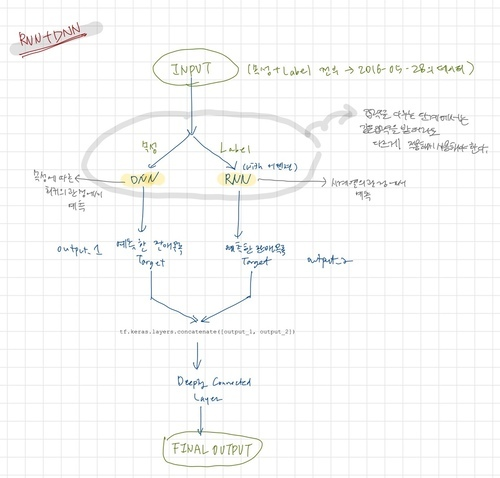



### TRAINING
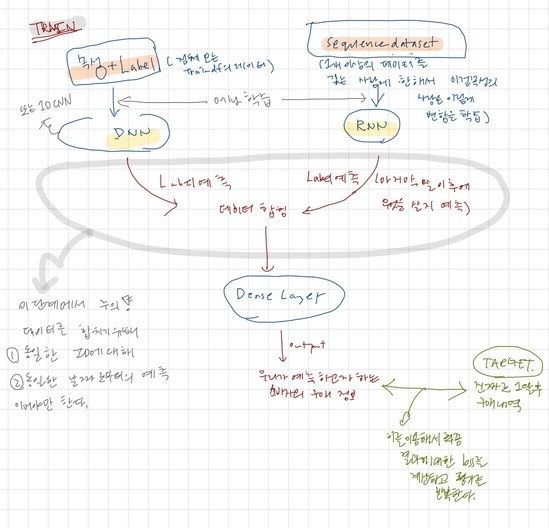

### EVALUATING
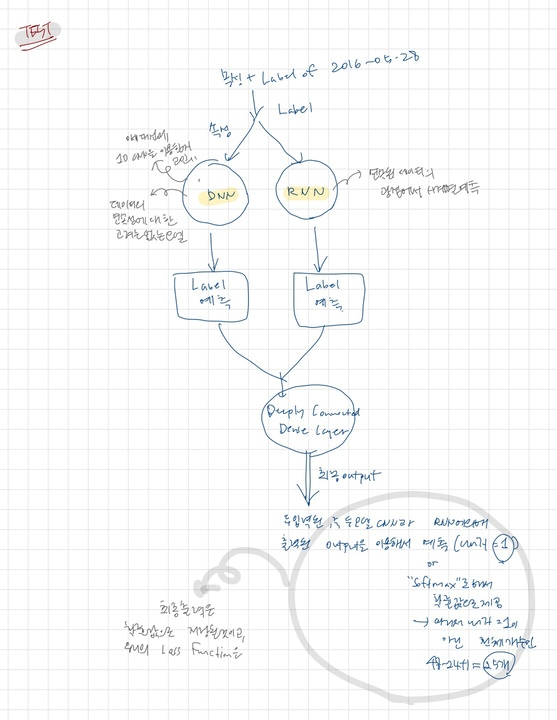

### Submission File
- For every user at each time point, you must predict a space-delimited list of the products they added.
- The file should contain a header and have the following format:


```
ncodpers,added_products
15889,ind_tjcr_fin_ult1
15890,ind_tjcr_fin_ult1 ind_recibo_ult1
15892,ind_nomina_ult1
15893,
etc.
```

